# Setup

In [ ]:
# !pip install google-play-scraper
# !pip install nltk
# !pip install seaborn

# Imports

In [1]:
from google_play_scraper import app
from google_play_scraper import Sort, reviews_all

import pandas as pd
import numpy as np

In [2]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [64]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

# Scrape Data

In [78]:
def get_df(app_id):
    
    us_reviews = reviews_all(
    app_id,
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    country='uk', # defaults to 'us'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
    )
    
    df = pd.DataFrame(np.array(us_reviews),columns=['review'])
    df = df.join(pd.DataFrame(df.pop('review').tolist()))
    df = df.drop(columns = ['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'replyContent', 'repliedAt'])
    
    return df 

# App 1: AO Surgery Reference

In [5]:
df = get_df('af.org.aofoundation.AOSR')
df

,content,score,at
0,I wish if there is another application for ele...,4,2023-03-09 09:11:06
1,App didn't work for one month approx.,1,2023-02-26 17:31:25
2,"O'ta tushunarli, qulay",5,2022-08-19 16:31:05
3,great,5,2022-07-05 19:30:01
4,Amazing app. Maybe a few more options for deve...,5,2022-06-12 20:49:08
...,...,...,...
301,Cool,4,2011-11-29 06:06:30
302,Great surgery reference for CMF cases.,5,2011-10-16 05:34:06
303,I wish they had more than ortho. Needa more va...,4,2011-10-03 00:14:29
304,Very useful...,5,2011-09-20 19:34:13


### Sentiment Analysis - AO Surgery Reference

In [6]:
print(df['content'][0])
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(df['content'][0])

I wish if there is another application for elective surgeries "arthroscopy, arthroplasty, etc."


{'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'compound': 0.4019}

In [7]:
print(df['content'][1])
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(df['content'][1])

App didn't work for one month approx.


{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [8]:
print(df['content'][3])
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(df['content'][3])

great


{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6249}

### Rating Analysis - AO Surgery Reference

In [9]:
df['month_year'] = df['at'].apply(lambda x: x.strftime('%Y-%m')) 
df

,content,score,at,month_year
0,I wish if there is another application for ele...,4,2023-03-09 09:11:06,2023-03
1,App didn't work for one month approx.,1,2023-02-26 17:31:25,2023-02
2,"O'ta tushunarli, qulay",5,2022-08-19 16:31:05,2022-08
3,great,5,2022-07-05 19:30:01,2022-07
4,Amazing app. Maybe a few more options for deve...,5,2022-06-12 20:49:08,2022-06
...,...,...,...,...
301,Cool,4,2011-11-29 06:06:30,2011-11
302,Great surgery reference for CMF cases.,5,2011-10-16 05:34:06,2011-10
303,I wish they had more than ortho. Needa more va...,4,2011-10-03 00:14:29,2011-10
304,Very useful...,5,2011-09-20 19:34:13,2011-09


In [80]:
df_rating_counts = df.groupby('month_year') \
       .agg({'content':'size', 'score':'mean'}) \
       .rename(columns={'content':'count','score':'mean_score'}) \
       .reset_index()
    
df_rating_counts

,month_year,count,mean_score
0,2011-09,2,5.0
1,2011-10,2,4.5
2,2011-11,1,4.0
3,2012-01,3,5.0
4,2012-02,4,5.0
...,...,...,...
115,2022-06,2,3.0
116,2022-07,1,5.0
117,2022-08,1,5.0
118,2023-02,1,1.0


In [81]:
def get_filled_dates(df_rating_counts):

    idx = pd.date_range(df_rating_counts['month_year'][0], '2023-04', freq='M')
    df2 = pd.DataFrame(idx)
    df2.columns = ['month_year']
    df2['month_year'] = df2['month_year'].apply(lambda x: x.strftime('%Y-%m'))
    df2 = df2.merge(df_rating_counts, on='month_year', how='left').fillna(0)
    df_rating_counts = df2
    
    return df2

In [82]:
df_rating_counts = get_filled_dates(df_rating_counts)
df_rating_counts['month_year'] = pd.to_datetime(df_rating_counts['month_year'])

df_rating_counts

,month_year,count,mean_score
0,2011-09-01,2.0,5.0
1,2011-10-01,2.0,4.5
2,2011-11-01,1.0,4.0
3,2011-12-01,0.0,0.0
4,2012-01-01,3.0,5.0
...,...,...,...
134,2022-11-01,0.0,0.0
135,2022-12-01,0.0,0.0
136,2023-01-01,0.0,0.0
137,2023-02-01,1.0,1.0


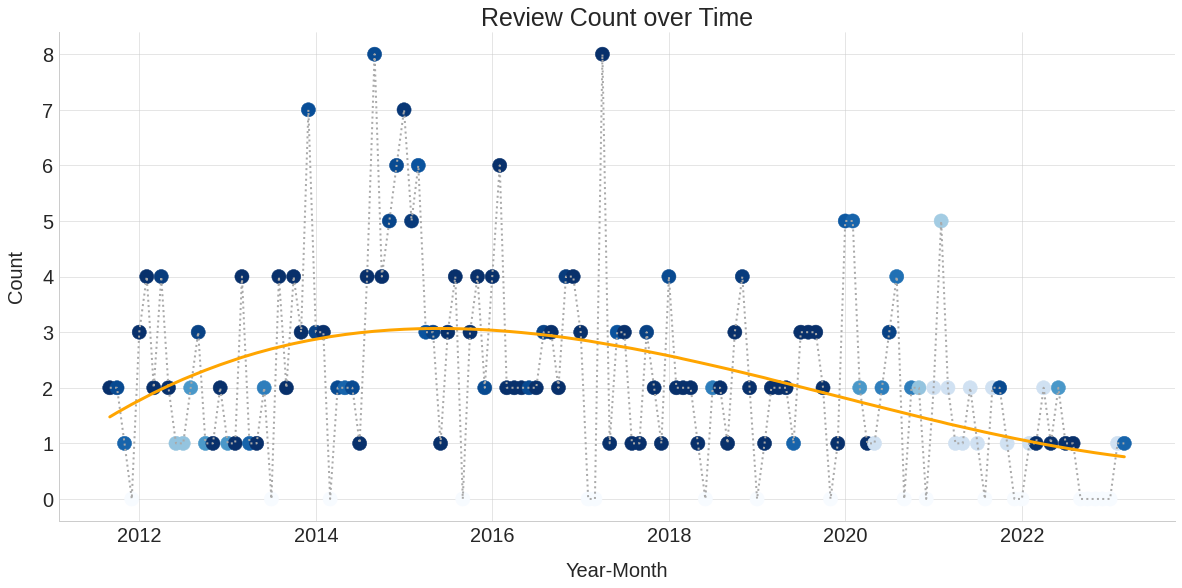

In [96]:
# Set the style of the plot
plt.style.use('seaborn-whitegrid')

# Set the figure size
plt.figure(figsize=(20, 9))

# Scatter plot
plt.scatter(df_rating_counts['month_year'], df_rating_counts['count'], c=df_rating_counts['mean_score'], cmap='Blues', marker='o', s=200)

# Lines between markers
plt.plot(df_rating_counts['month_year'], df_rating_counts['count'], color='darkgrey', linestyle='dotted')

# Line of best fit
x = np.arange(df_rating_counts['month_year'].size)
fit = np.polyfit(x, df_rating_counts['count'], deg=3)
fit_function = np.poly1d(fit)
plt.plot(df_rating_counts['month_year'], fit_function(x), color='orange', linewidth=3)

# Set the labels and title
plt.xlabel('Year-Month', fontsize=20, labelpad=16)
plt.ylabel('Count', fontsize=20, labelpad=16)
plt.title('Review Count over Time', fontsize=25)

#Set label sizes
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)

# Show the plot
plt.show()